In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv("/content/NSE-TATAGLOBAL.csv")
df.head(100)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
95,2018-05-14,280.00,281.35,251.85,257.00,255.90,16822847,43913.37
96,2018-05-11,284.40,290.50,284.40,287.00,287.50,1974327,5685.22
97,2018-05-10,292.95,293.00,283.45,284.15,285.25,1446384,4157.17
98,2018-05-09,289.60,294.35,288.60,292.00,292.00,1820409,5311.00


In [ ]:
df1=df.reset_index()['Close']

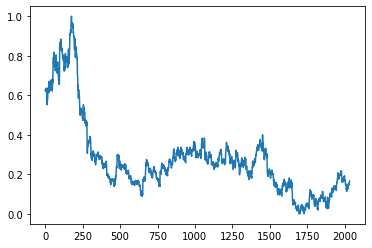

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

use min-max scalar to transform the values from 0 to 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

Train and Test Split

In [ ]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(1322, 713)

Data Preprocessing

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

reshaping our train set

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

*LSTM*

using a sequential model and adding the layers of the LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

 summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 12s 329ms/step - loss: 0.0271 - val_loss: 0.0033
Epoch 2/100
20/20 [==============================] - 4s 184ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 3/100
20/20 [==============================] - 5s 250ms/step - loss: 0.0019 - val_loss: 9.5602e-04
Epoch 4/100
20/20 [==============================] - 4s 182ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/100
20/20 [==============================] - 4s 176ms/step - loss: 0.0022 - val_loss: 8.8748e-04
Epoch 6/100
20/20 [==============================] - 5s 257ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/100
20/20 [==============================] - 4s 183ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
20/20 [==============================] - 4s 183ms/step - loss: 0.0014 - val_loss: 9.5968e-04
Epoch 9/100
20/20 [==============================] - 4s 182ms/step - loss: 0.0016 - val_loss: 8.8356e-04
Epoch 10/100
20/20 [==============================] - 4s 183ms/step - loss

In [ ]:
import tensorflow as tf
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

166.5764254342818

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

116.80178095613122

Green indicates the Predicted Data
Blue indicates the Complete Data
Orange indicates the Train Data

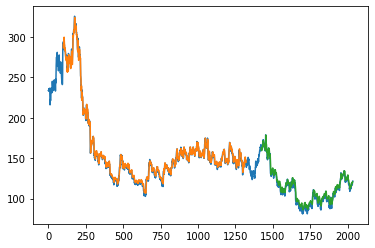

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

713

In [ ]:
x_input=test_data[613:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.17074783]
101
1 day input [0.13848039 0.14011438 0.13888889 0.13541667 0.14011438 0.1380719
 0.13071895 0.13071895 0.12867647 0.11846405 0.14644608 0.14808007
 0.15910948 0.15992647 0.15788399 0.16441993 0.17892157 0.17933007
 0.19260621 0.20812908 0.18974673 0.18055556 0.18239379 0.17708333
 0.17810458 0.18055556 0.17810458 0.17851307 0.19607843 0.18913399
 0.18954248 0.19403595 0.19444444 0.20200163 0.19771242 0.19934641
 0.19873366 0.1997549  0.2128268  0.21568627 0.20445261 0.21772876
 0.21098856 0.21425654 0.19750817 0.18811275 0.17851307 0.17381536
 0.16033497 0.16564542 0.17116013 0.17422386 0.18035131 0.17401961
 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065 0.17279412
 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222 0.17238562
 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268
 0.15196078 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745
 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967
 0.12806373 0.13031046 0.12724673 0

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

2035

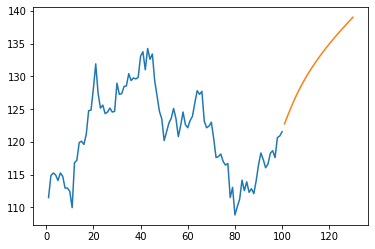

In [ ]:
import matplotlib.pyplot as plt
plt.plot(day_new,scaler.inverse_transform(df1[1935:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))